In this notebook, we want to increase the complexity of the transfer learning for the model SAM from meta. Inthe previous notebook, we tested a lean version of transfer learning with SAM. 

* 100 epochs
* 10 patience
* Pytorch only instead of mixing HuggingFace with PyTorch
    * It seems like it's hard to rely only on PyTorch

In [8]:
# Setting up the enviroment
# TODO: Where to find the specific versions of the packages to install?
%pip install transformers
%pip install datasets
%pip install Pillow
%pip install torch
%pip install torchvision
#%pip install torch==2.0.0
#%pip install  torchvision==0.15
%pip install torchmetrics
%pip install tdqm

# Using old version of torch to avoid else cuda is not available

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [4]:
%matplotlib inline

In [5]:
# Constants
BATCH_SIZE = 32
SIZE = (256, 256)
MASK_SUFFIX = "_mask.png"

In [6]:
import os

cwd = os.getcwd()
print(cwd)

/home/mark/work/MultiModal


In [7]:
from datasets import load_dataset, Image
data_dir = os.path.join(cwd, 'data')

one_class_flipped_dataset = "sentinel-1-flipped-one-class/train/"
two_class_augmented_dataset = "sentinel-1-augmented-two-class/train/"

current_data_dir = os.path.join(data_dir, one_class_flipped_dataset)
current_data_dir 

/home/mark/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/home/mark/work/MultiModal/data/sentinel-1-flipped-one-class/train/'

In [9]:
# Load and split the dataset 

ds = load_dataset(path = current_data_dir, split='train')
ds = ds.train_test_split(test_size=0.2, seed=42)
ds



DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 320
    })
    test: Dataset({
        features: ['image'],
        num_rows: 80
    })
})

In [10]:
# Check the classes (It can be more than 1, depending on the dataset)
import pandas as pd

csv_path = os.path.join(current_data_dir, '_classes.csv')

print(csv_path)

df = pd.read_csv(csv_path)
df

/home/mark/work/MultiModal/data/sentinel-1-flipped-one-class/train/_classes.csv


,Pixel Value,Class
0,0,background
1,1,water


In [11]:
# Still data exploration
sample = ds['train'][2]
sample 

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x140>}

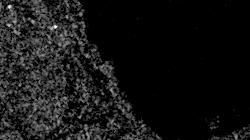

In [12]:
sample_image = sample['image']
sample_image

In [13]:
sample_image_filename = sample_image.filename
sample_image_filename

'/home/mark/work/MultiModal/data/sentinel-1-flipped-one-class/train/sentinel1_VH_20231009_png.rf.5747dd7ac9c104dcec9c53f4ebe8051d.jpg'

In [14]:
# Find the mask for the sample_image
sample_mask_filename = sample_image_filename.replace(".jpg", MASK_SUFFIX)
sample_mask_filename

'/home/mark/work/MultiModal/data/sentinel-1-flipped-one-class/train/sentinel1_VH_20231009_png.rf.5747dd7ac9c104dcec9c53f4ebe8051d_mask.png'

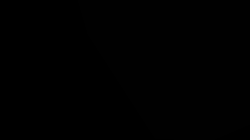

In [15]:
from PIL import Image
sample_image_mask = Image.open(sample_mask_filename)
sample_image_mask

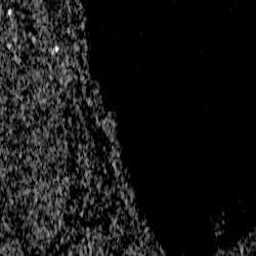

In [16]:
# Resize the image and the mask
sample_image_resized = sample_image.resize(SIZE)
sample_image_resized


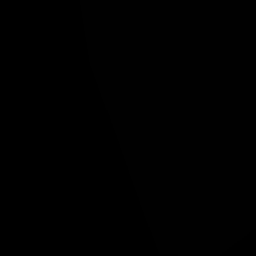

In [17]:
sample_image_mask_resized = sample_image_mask.resize(SIZE)
sample_image_mask_resized

In [18]:
# Turning the sample image and mask into arrays

import numpy as np

sample_image_array = np.array(sample_image_resized)
sample_image_array

array([[[56, 56, 56],
        [20, 20, 20],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[43, 43, 43],
        [27, 27, 27],
        [ 3,  3,  3],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[22, 22, 22],
        [42, 42, 42],
        [12, 12, 12],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[71, 71, 71],
        [72, 72, 72],
        [79, 79, 79],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[32, 32, 32],
        [21, 21, 21],
        [41, 41, 41],
        ...,
        [ 5,  5,  5],
        [ 0,  0,  0],
        [ 1,  1,  1]],

       [[12, 12, 12],
        [ 0,  0,  0],
        [20, 20, 20],
        ...,
        [ 7,  7,  7],
        [ 0,  0,  0],
        [ 1,  1,  1]]], dtype=uint8)

In [19]:
sample_image_mask_array = np.array(sample_image_mask_resized)
sample_image_mask_array


array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [20]:
# Check the shape of the arrays

sample_image_array.shape, sample_image_mask_array.shape


((256, 256, 3), (256, 256))

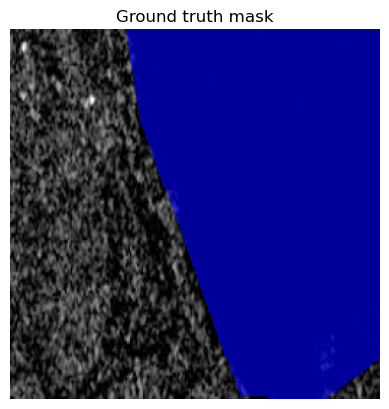

In [ ]:
# Plot ground truth and mask of the example image

import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax):
    # Define colors for the three classes (maybe rather just black and white?)
    water_color = np.array([0, 0, 1, 0.6]) # Water

    # Get height and weight from the mask
    h,w = mask.shape[-2:]

    # Create an empty image with the same height and Width but with 4th channel (Alpha)
    mask_image = np.zeros((h, w, 4))

    # Apply the colors based on the mask value

    mask_image[mask == 1] = water_color

    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(sample_image_resized))


ground_truth_seg = sample_image_mask_array

show_mask(ground_truth_seg, axes)

axes.title.set_text("Ground truth mask")
axes.axis("off")

plt.show()

In [22]:
def get_bounding_box(ground_truth_map):
    # Get indices of the positive mask area
    y_indices, x_indices = np.where(ground_truth_map > 0)

    if len(x_indices) == 0 or len(y_indices) == 0:
        # If no positive pixels are found, return a default box or raise an error
        return [0, 0, 0, 0]  # or handle as needed

    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    H, W = ground_truth_map.shape

    # Apply perturbation, keeping within bounds 
    # TODO: Check if this is needed!
    # x_min = max(0, x_min - np.random.randint(0, 20))
    # x_max = min(W, x_max + np.random.randint(0, 20))
    # y_min = max(0, y_min - np.random.randint(0, 20))
    # y_max = min(H, y_max + np.random.randint(0, 20))

    bbox = [x_min, y_min, x_max, y_max]
    return bbox






In [23]:
import os
import numpy as np
from numpy import asarray
# Create custom Pytorch dataset

from torch.utils.data import Dataset
import torch

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__ (self, idx):
    item = self.dataset[idx]
    image = item["image"]
    image_path = image.filename
    image = image.resize(SIZE)
    image_rgb = image.convert("RGB")

    mask_path = image_path.replace(".jpg", MASK_SUFFIX)
    mask = Image.open(mask_path)
    mask = mask.resize(SIZE)
    mask_array = asarray(mask)


    ground_truth_mask = torch.from_numpy(np.array(mask, copy=True))

    # Get bounding box
    prompt = get_bounding_box(ground_truth_mask)

    # Prepare image and prompt for the model
    inputs = self.processor(image_rgb, input_boxes=[[prompt]],
                            return_tensors="pt")

    # Remove batch dimension (processor adds this by default)
    # (Batch, Channels, Height, Width)
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # Add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs





In [24]:
# Download the processor

from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")


/home/mark/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/mark/.local/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_

In [25]:
# Print the processor
print(processor)

SamProcessor:
- image_processor: SamImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SamImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "mask_pad_size": {
    "height": 256,
    "width": 256
  },
  "mask_size": {
    "longest_edge": 256
  },
  "pad_size": {
    "height": 1024,
    "width": 1024
  },
  "processor_class": "SamProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1024
  }
}


{
  "processor_class": "SamProcessor"
}



In [26]:
# Create the train and test datasets
train_dataset = SAMDataset(ds['train'], processor)
test_dataset = SAMDataset(ds['test'], processor)

In [27]:
train_dataset[0]

{'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1008]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-

In [28]:
# Create the dataloaders

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [29]:
train_dataloader.dataset[0]

{'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1008]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-

In [30]:
# Load the model

from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# Print the model
print(model)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [31]:
# Freeze the vision_encoder and the prompt_encoder. Make sure to only compute the gradients for the mask_decoder

for name, param in model.named_parameters():
  if "vision_encoder" in name or "prompt_encoder" in name:
    param.requires_grad = False

In [ ]:
import torch
# Check if cuda is available - TODO: How can it be unavailable?

torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "mps") # mps is for when not using cuda but using mac
device

device(type='mps')

In [ ]:
# Model training and evaluation


import torch
import os
import torch.nn.functional as F
from torchmetrics import IoU
from tqdm import tqdm
import numpy as np
from statistics import mean


# Training contrants
EPOCHS = 10
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.01

version = "1"
current_date_and_time = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")
model_dir = os.path.join(cwd, "model")
model_name = "sam-vit-base-water-segmentation-" + version


# Optimizer 
# TODO: Check if this is the best optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


# Loss function
# TODO: Check if this is the best loss function
seg_loss = torch.nn.BCEWithLogitsLoss()

# Metrics
iou = IoU(num_classes=1)

# Training loop

for epoch in range(EPOCHS):
    epoch_losses = []
    epoch_ious = []
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        optimizer.zero_grad()

        # Move inputs to GPU
        pixel_values = batch["pixel_values"].to(device)
        input_boxes = batch["input_boxes"].to(device)
        ground_truth_mask = batch["ground_truth_mask"].to(device)

        # Forward pass
        outputs = model(pixel_values=pixel_values, input_boxes=input_boxes, multimask_output=False)

        # Compute loss
        loss = seg_loss(outputs, ground_truth_mask.unsqueeze(1))
        epoch_losses.append(loss.item())

        # Compute IoU
        iou.update(outputs, ground_truth_mask)
        epoch_ious.append(iou.compute())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute mean loss and IoU
    mean_loss = mean(epoch_losses)
    mean_iou = mean(epoch_ious)

    # Save the mean loss and IoU of the training set
    with open(os.path.join(model_dir, model_name + "training_loss_iou.txt"), "a") as f:
        f.write(f"Epoch {epoch + 1}/{EPOCHS} - Loss: {mean_loss:.4f}, IoU: {mean_iou:.4f}\n")

    print(f"Epoch {epoch + 1}/{EPOCHS} - Loss: {mean_loss:.4f}, IoU: {mean_iou:.4f}")

# Model evaluation 

    for batch in tqdm(test_dataloader, desc="Evaluating"):
        pixel_values = batch["pixel_values"].to(device)
        input_boxes = batch["input_boxes"].to(device)
        ground_truth_mask = batch["ground_truth_mask"].to(device)

        # Forward pass
        outputs = model(pixel_values=pixel_values, input_boxes=input_boxes, multimask_output=False)

        # Compute IoU
        iou.update(outputs, ground_truth_mask)

    # Compute mean IoU
    mean_iou = iou.compute()
    print(f"Mean IoU: {mean_iou:.4f}")

    # Save the mean IoU of the testing set  
    with open(os.path.join(model_dir, model_name + "testing_iou.txt"), "a") as f:
        f.write(f"Epoch {epoch + 1}/{EPOCHS} - Mean IoU: {mean_iou:.4f}\n")

# Save the model and the optimizer
torch.save(model.state_dict(), os.path.join(model_dir, model_name + ".pth"))
torch.save(optimizer.state_dict(), os.path.join(model_dir, model_name + "_optimizer.pth"))


In [ ]:
idx = 1
sampple = ds['test'][idx]
sample


sample_image = sample['image']
sample_image_filename = sample_image.filename
sample_image_resized = sample_image.resize(SIZE)
sample_image_resized

In [ ]:
sample_mask_filename = sample_image_filename.replace(".jpg", MASK_SUFFIX)
sample_mask = Image.open(sample_mask_filename)
sample_mask_resized = sample_mask.resize(SIZE)
sample_mask_resized

In [ ]:
sample_image_array = np.array(sample_image_resized)


In [ ]:
sample_image_mask_array = np.array(sample_mask_resized)

In [ ]:
# Convert the ground truth mask to numpy array
ground_truth_mask = np.array(sample_mask_resized)

# Get bounding box from ground truth mask
prompt = get_bounding_box(ground_truth_mask)

# Get box prompt
prompt = get_bounding_box(ground_truth_mask)

# Prepare input image and bounding box prompt for the model
inputs = processor(sample_image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k, v in inputs.items():
    print(k, v.shape)

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    # Perform inference
    outputs = model(**inputs, multimask_output=True)

# Apply sigmoid to convert logits to probabilities
tl_sam_seg_prob = torch.sigmoid(outputs.pred_masks[0, 0, :, :])  # Corrected indexing

# Convert probabilities to binary mask using a threshold
tl_sam_seg = (tl_sam_seg_prob > 0.5).cpu().numpy().squeeze()

In [ ]:
print(outputs.pred_masks.shape)

In [ ]:
# prepare image and box prompt for the model
inputs = processor(sample_image, input_boxes=[[prompt]], return_tensors=python
tl_sam_seg_prob = tl_sam_seg_prob.cpu().numpy().squeeze()

# convert probabilities to binary mask (0 or 1) for thresholding
tl_sam_seg = (tl_sam_seg_prob > 0.5).astype(np.uint8)

# plot predicted mask
fig, ax_pred = plt.subplots()
ax_pred.imshow(np.array(sample_image))
show_mask(tl_sam_seg, ax_pred)
ax_pred.title.set_text("Predicted Mask")
ax_pred.axis("off")

# plot ground truth mask
fig, ax_gt = plt.subplots()
ax_gt.imshow(np.array(sample_image))
show_mask(tl_sam_seg, ax_gt)
ax_gt.title.set_text("Ground Truth Mask")
ax_gt.axis("off")

plt.show()
